# Projeto Unidade II : Ajuste de Curvas via MMQ e RBF.

Seja o sistema dinâmico dado pela função não linear,

$$y[n] = f(\hat{y}[n-1],\hat{y}[n-2],u[n],u[n-1]).$$

Cujos conjuntos entradas / saídas são apresentados via arquivos:

1. **dados\_01.dat** e,
2. **dados\_02.dat**.

Implemente um identificador para a dinâmica do sistema, utilizando o **Método dos Mínimos Quadrados(MMQ)** e **via Funções de Base Radial (RBF)** que deve

1. ser treinado com **dados\_01.dat** e,
2. testado e validado com **dados\_02.dat**.

Compare os modelos e apresente o de melhor resultado com conclusões.


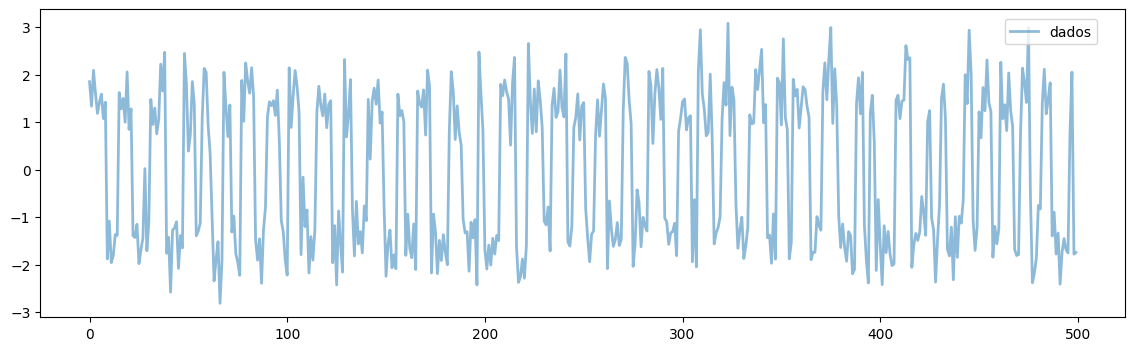

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
from scipy.signal import butter, sosfiltfilt

data = np.loadtxt('D:\dados_01.dat')
data2 = np.loadtxt('D:\dados_02.dat')

t = data[:,0]
u = data[:,1]
y = data[:,2]

plt.figure(figsize = (14,4))
plt.plot(t,y, lw = 2, alpha = .5, label = 'dados')
plt.legend(loc = 'upper right', bbox_to_anchor = (.98,.99))
plt.show()

## Etapa de Treinamento

In [ ]:
#MMQ
p = np.poly1d( np.polyfit(y, f_train, 1) )
t = np.linspace(-3, 3, 500)
#
EMQ = np.mean((y - f_train)**2)
#
plt.figure(figsize = (14,4))
plt.suptitle("Erro de treinamento", fontsize=18, y=0.95)
plt.plot(y, f_train, 'o', t, p(t), '-')
plt.text(2.5, 2.7, 'EMQ = %.4f' %EMQ)
#plt.text(2.5, 2, 'STD = %.4f' %STD)
plt.axis('off')
plt.show()

Erro Médio Quadrático (EMQ): 0.45730


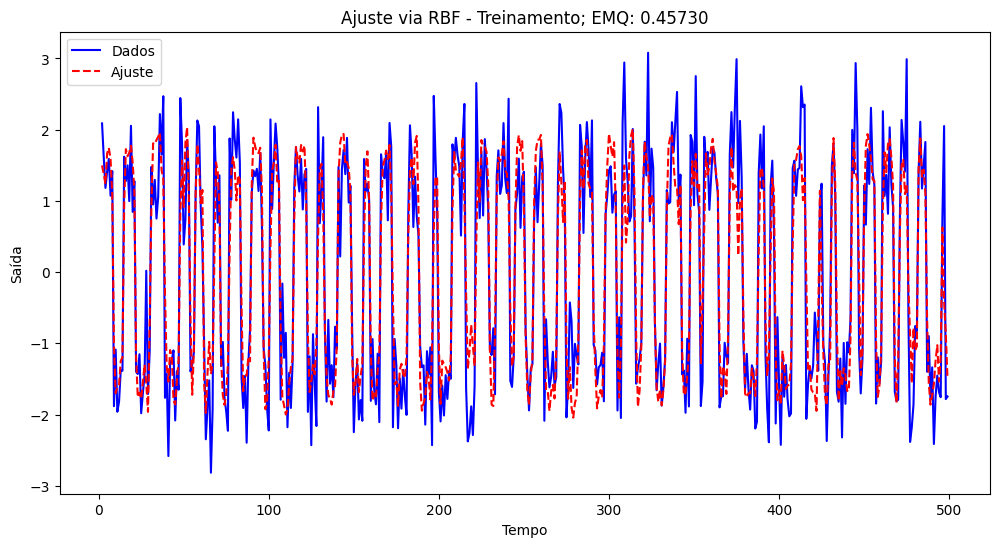

In [52]:
X = np.column_stack([y[1:-1], y[:-2], u[2:], u[1:-1]]) 
Y = y[2:]

sigma = 4.0

c = np.linspace(u[0], u[499], 4)
#np.random.seed(42) 
#indices = np.random.choice(len(X), size=c, replace=False)
#centros = X[indices]

def rbf(x, c, sigma):
    return np.exp(-np.sum((x - c)**2) / (2 * sigma**2))

phi = np.zeros((len(X), len(c)))

for k in range(len(X)):
    for i in range(len(c)):
        phi[k, i] = rbf(X[k], c[i], sigma)


w = np.dot(la.pinv(phi), Y)

y_est = phi @ w

EMQ = np.mean((Y - y_est) ** 2)
print(f"Erro Médio Quadrático (EMQ): {EMQ:.5f}")


plt.figure(figsize=(12, 6))
plt.plot(t[2:], Y, color="blue", label='Dados')
plt.plot(t[2:], y_est, "--r", label='Ajuste')
plt.xlabel("Tempo")
plt.ylabel("Saída")
plt.title(f"Ajuste via RBF - Treinamento; EMQ: {EMQ:.5f}")
plt.legend()
plt.show()

## Etapa de Testes

In [ ]:
#======= Band-Pass Filter =====================================================

def bandpass(data: np.ndarray, edges: list[float], sample_rate: float, poles: int = 5):
    sos = butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data


#============ Teste =======================================================


In [ ]:
f_val = bandpass(f_val, [0.1, 20], 100)

EMQ = np.mean((y2 - f_val)**2)

N2 = 70
plt.figure(figsize = (14,4))
plt.suptitle("Etapa de teste", fontsize=18, y=0.95)
plt.plot(t2[0:N2],y2[0:N2],'o-', lw = 2, alpha = .5, label = 'dados_02')
plt.plot(t2[0:N2],f_val[0:N2],'r--', lw = 2, alpha = .5, label = 'RBF_teste')
plt.text(2.5, 1.4, 'EMQ da RBF = %.4f' %EMQ)
plt.legend(loc = 'upper right', bbox_to_anchor = (.98,.99))
plt.axis('off')

plt.tight_layout()
plt.show()

## Etapa de Validação

In [ ]:
p_in = np.ones((len(u2)))
#p_in = np.random.rand(len(u2))